# Семинар 2: байесовские линейные модели регрессии

Часть материала взята из [источник 1](https://jessicastringham.net/2018/01/10/bayesian-linreg-plots/), [источник 2](https://github.com/jessstringham/notebooks/blob/master/2018-01-10-bayesian-linreg-plots.ipynb)

Автор: Оганов Александр

На этом семинаре мы:
1) Разберем байесовскую линейную регрессию и посмотрим преимущества байесовского вывода

2) Посмотрим на метод релевантных векторов на синтетических данных и сравним с Ridge и Lasso регрессией

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import RidgeCV, LassoCV, Lasso
from sklearn.svm import SVR
from sklearn.metrics.pairwise import rbf_kernel

%matplotlib inline

In [2]:
def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

def get_features_pol(X, d):
    return np.hstack([X[:, None] ** i for i in range(d)])

def gen_batch_linear(n, w, beta):
    X = np.random.uniform(-1, 1, (n))
    X = get_features_pol(X, d)
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t


# Байесовская линейная регрессия

Сгенерируем синтетические данные

In [3]:
d = 7
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1


beta_true = 100
alpha = np.ones(d) * 20

In [4]:
n = 200
X_train, t_train = gen_batch_linear(n, w_true, beta_true)
X_test, t_test = gen_batch_linear(n, w_true, beta_true)

x_grid = np.linspace(-1.6, 1.6, 1000)
X_manifold = get_features_pol(x_grid, d)

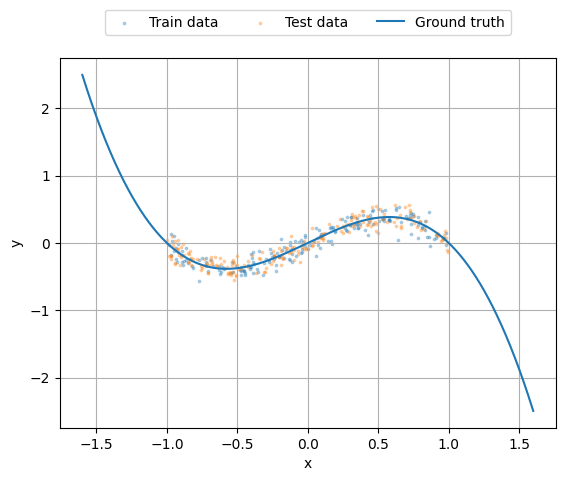

In [5]:
fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_manifold[:, 1], X_manifold.dot(w_true), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
ax.grid()
plt.show()

## Байесовская линейная регрессия

$(T, X)$ - обучающая выборка

Определим вероятностную модель следующим образом:

$$p(T \mid X, w) = \mathcal{N}(T \mid Xw, \beta^{-1}I), \quad p(w) = \mathcal{N}(w \mid 0, \alpha^{-1} I)$$


Тогда следуя лекции получим апостериорное распределение на $w$:

$$p(w \mid X, T) = \mathcal{N}(w \mid \mu, \Sigma)$$
$$\Sigma = (\beta X^T X + \alpha I)^{-1}$$
$$\mu = \beta \Sigma X^T T $$

Для предсказания мы используем:

$$ p(t_* \mid x_*, X, T) = \int p(t_*, w \mid x_*, X, T) dw = \int p(t_* \mid x_*, w) p(w \mid X, T) dw =\\
    = \int \mathcal{N} (t_* \mid x_*^T w, \beta^{-1}) \mathcal{N}(w \mid \mu, \Sigma) dw $$
    
Используя результаты лекции получим:

$$ p(t_* \mid x_*, X, T) =  \mathcal{N}(t_* \mid x_*^T \mu, x_*^T\Sigma x_* + \beta^{-1}) $$


In [6]:
def get_w_sigma(X, t, alpha, beta):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
     
    sigma = np.linalg.inv(beta * (X.T @ X) + np.diag(alpha))
    w = beta * sigma @ X.T @ t
    return w, sigma

def get_bayes_predict(X_test, w, sigma, beta):
    """Computes mean and variances of the posterior predictive distribution."""
    
    t_mean = X_test.dot(w.ravel())
    t_sigma = np.sum(X_test.dot(sigma) * X_test, axis=1) + 1 / beta
    return t_mean, t_sigma

In [7]:
def show_bayes_lin_reg(X_train, t_train, X_test, t_test, w, x_grid, t_manifold, t_mean, t_var, suff, ax, idx=1):
    t_std = np.sqrt(t_var)
    
    
    ax.set_title(f"{suff}")
    
    ax.scatter(X_train[:, idx], t_train,  s=14, label='Train data', alpha=1)
    ax.scatter(X_test[:, idx], t_test, s=3, label='Test data', alpha=0.3)
    
    ax.plot(x_grid, t_mean, label='Bayes linear')
    ax.fill_between(x_grid, t_mean - t_std, t_mean + t_std, label=r'$\pm \sigma$', color='b', alpha=0.2)
    
    ax.plot(x_grid, t_manifold, label='ground truth', c='g', alpha=0.8)
    
    ax.set_ylim(-1, 1.2)
    ax.legend(loc='upper right')
    ax.grid()
    
def show_bayes_posterior_sample(w_mean, w_var, X_test, t_test, x_grid, X_manifold, t_manifold, suff, ax):
    
    w_sampled = np.random.randn(10, X_test.shape[1]) @ np.linalg.cholesky(w_var) + w_mean
    
    ax.set_title(f"{suff}")

    for w in w_sampled:
        ax.plot(x_grid, X_manifold.dot(w.ravel()), c='r', alpha=0.4)
    
    ax.plot(x_grid, t_manifold, label='ground truth', c='b', alpha=0.8)
    
    ax.set_ylim(-1, 1.2)
    ax.legend(loc='upper right')
    ax.grid()

In [8]:
N_list = [3, 8, 20, 40, 100, 200]

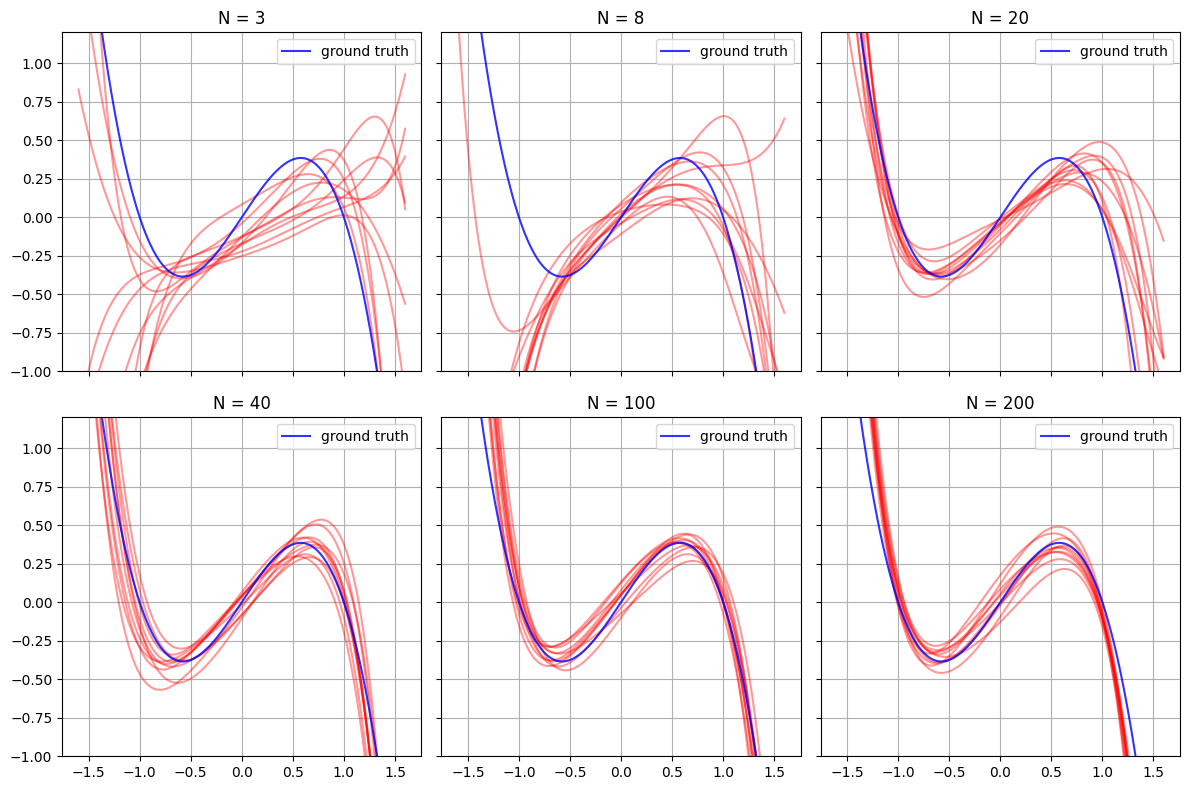

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, last_idx in enumerate(N_list):

    w_bayes, sigma_bayes = get_w_sigma(X_train[:last_idx], t_train[:last_idx], alpha, beta_true)
    t_mean, t_var = get_bayes_predict(X_manifold, w_bayes, sigma_bayes, beta_true)
    
    show_bayes_posterior_sample(
        w_mean=w_bayes, w_var=sigma_bayes, 
        X_test=X_test, t_test=t_test, 
        x_grid=x_grid, X_manifold=X_manifold, t_manifold=X_manifold.dot(w_true),
        suff=f"N = {last_idx}",
        ax=ax.ravel()[i]
    )

plt.tight_layout()
plt.show()

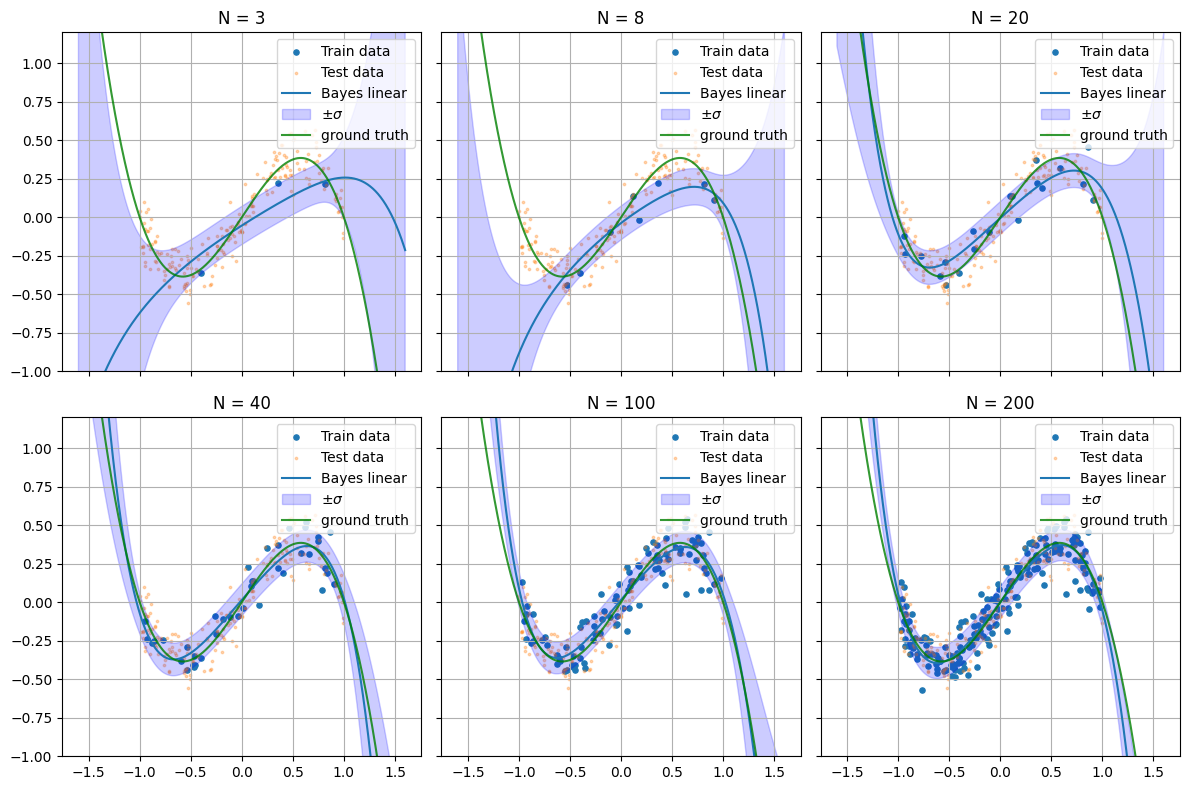

In [10]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, last_idx in enumerate(N_list):

    w_bayes, sigma_bayes = get_w_sigma(X_train[:last_idx], t_train[:last_idx], alpha, beta_true)
    t_mean, t_var = get_bayes_predict(X_manifold, w_bayes, sigma_bayes, beta_true)
    
    show_bayes_lin_reg(
        X_train=X_train[:last_idx], t_train=t_train[:last_idx],
        X_test=X_test, t_test=t_test,
        w=w_bayes, x_grid=x_grid,  t_manifold=X_manifold.dot(w_true),
        t_mean=t_mean, t_var=t_var,
        suff=f"N = {last_idx}",
        ax=ax.ravel()[i]
    )

plt.tight_layout()
plt.show()

Пример для данных с RBF ядром

In [11]:
# Data generation
def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 200
n_test = 1000
d = n + 1
beta_true = 100
alpha = np.ones(d) * 20

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n_test, beta_true)

# RBF-transform
X_train = rbf_kernel(points_train[:, None], points_train[:, None])
X_test = rbf_kernel(points_test[:, None], points_train[:, None])

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n_test, 1)), X_test))

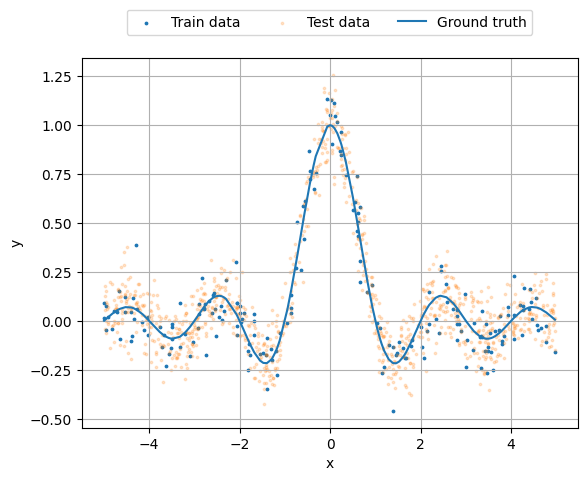

In [12]:
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=1)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.2)
ax.plot(points_train, np.sinc(points_train), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
ax.grid()
plt.show()

In [13]:
idx = np.arange(n)
np.random.shuffle(idx)

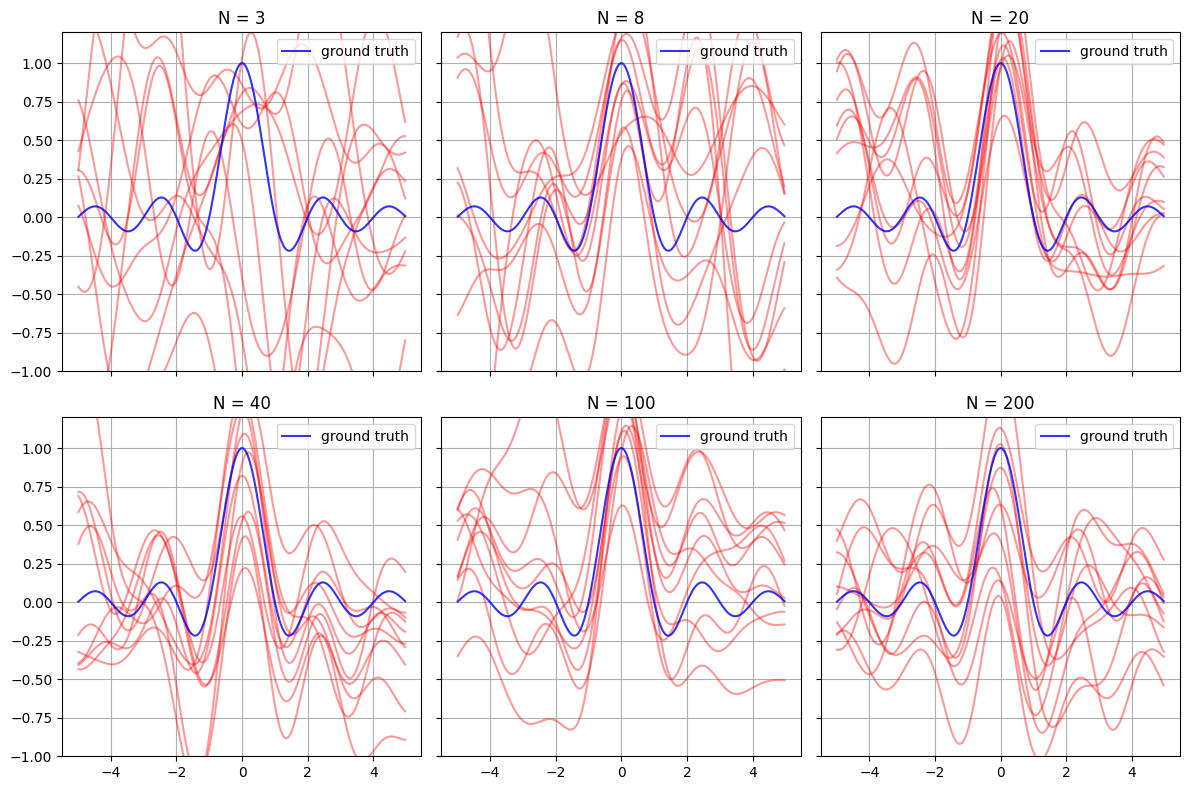

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, last_idx in enumerate(N_list):

    w_bayes, sigma_bayes = get_w_sigma(X_train[idx[:last_idx]], t_train[idx[:last_idx]], alpha, beta_true)
    t_mean, t_var = get_bayes_predict(X_test, w_bayes, sigma_bayes, beta_true)
    
    show_bayes_posterior_sample(
        w_mean=w_bayes, w_var=sigma_bayes, 
        X_test=X_test, t_test=t_test, 
        x_grid=points_test, X_manifold=X_test, t_manifold=np.sinc(points_test),
        suff=f"N = {last_idx}",
        ax=ax.ravel()[i]
    )

plt.tight_layout()
plt.show()

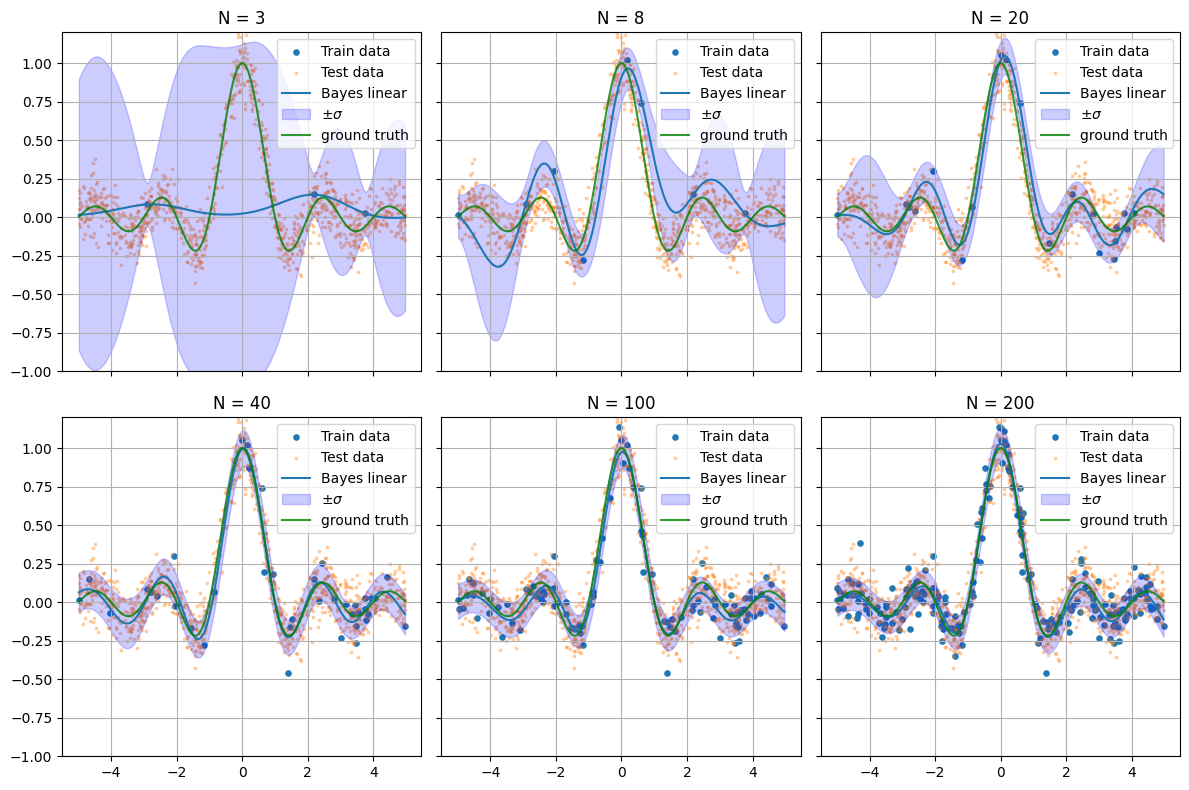

In [15]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)

for i, last_idx in enumerate(N_list):

    w_bayes, sigma_bayes = get_w_sigma(X_train[idx[:last_idx]], t_train[idx[:last_idx]], alpha, beta_true)
    t_mean, t_var = get_bayes_predict(X_test, w_bayes, sigma_bayes, beta_true)

    show_bayes_lin_reg(
        X_train=points_train[:, None][idx[:last_idx]], t_train=t_train[idx[:last_idx]],
        X_test=points_test[:, None], t_test=t_test,
        w=w_bayes, x_grid=points_test,  t_manifold=np.sinc(points_test),
        t_mean=t_mean, t_var=t_var,
        suff=f"N = {last_idx}",
        ax=ax.ravel()[i], idx=0
    )

plt.tight_layout()
plt.show()
    

## Метод релевантных векторов

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

In [16]:
INF = 1e8

def get_w_sigma(X, t, alpha, beta):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
     
    sigma = np.linalg.inv(beta * (X.T @ X) + np.diag(alpha))
    w = beta * sigma @ X.T @ t
    return w, sigma


def update_alpha_beta(X, t, alpha, beta):
    
    
    """Update the hyperperemeters to increase evidence"""
    n, d = X.shape
   
    
    w, sigma = get_w_sigma(X, t, alpha, beta)
    alpha = (1 - alpha * np.diagonal(sigma))
    beta = (n - alpha.sum()) / np.linalg.norm(t - X @ w) ** 2
    alpha /= (w ** 2)
    
    return alpha, beta


def fit_rvr(X, t, max_iter=10000):
    """Train the Relevance Vector Regression model"""
    d = X.shape[1]
    alpha, beta = np.ones(d), np.ones(d)
    w, sigma = np.zeros(d), np.zeros((d, d))
    for i in range(max_iter):
        mask = alpha < INF
        alpha_t, beta = update_alpha_beta(X[:, mask], t, alpha[mask], beta)
        alpha[~mask] = np.inf
        alpha[mask] = alpha_t
    
    mask = alpha < INF
    w[mask], sigma_new = get_w_sigma(X[:, mask], t, alpha[mask], beta)
    sigma[mask[:, None] & mask[None, :]] = sigma_new.ravel()
    return w, sigma, alpha, beta

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

In [17]:
np.random.seed(123)

In [18]:
def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-1, 1, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1
beta_true = 100

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

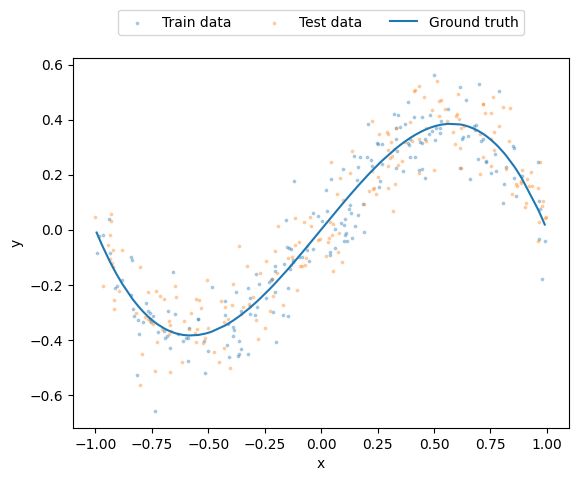

In [19]:
fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()


Обучим метод релевантных векторов

In [20]:
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [21]:
args = np.argwhere(w_rvr != 0).ravel()
print("Номера ненулевых признаков:", args)
print("Веса признаков:", w_rvr[args])

Номера ненулевых признаков: [0 1 3]
Веса признаков: [-0.00851731  1.00443648 -1.02131241]


Сравним метод с Lasso и Ridge регрессией

In [23]:
alpha_grid = 10. ** np.linspace(-6, 3, 100)

In [24]:
lasso = LassoCV(cv=5, alphas=alpha_grid,
                fit_intercept=False, max_iter=2000000).fit(X_train, t_train)
w_lasso = lasso.coef_

/home/alexandr/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069098023442975, tolerance: 0.0012854460800422094
  model = cd_fast.enet_coordinate_descent_gram(


In [25]:
ridge = RidgeCV(cv=20, alphas=alpha_grid,
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

Relevance Vector Regression
Features remaining: 3 / 21
Train error: 0.009052796709304888
Test error:  0.00979346412659534
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 0.009095034553223615
Test error:  0.00996144205308367
--------------------------------------------------
Lasso Regression
Features remaining: 9 / 21
Train error: 0.008878963547469502
Test error:  0.010139505424318273


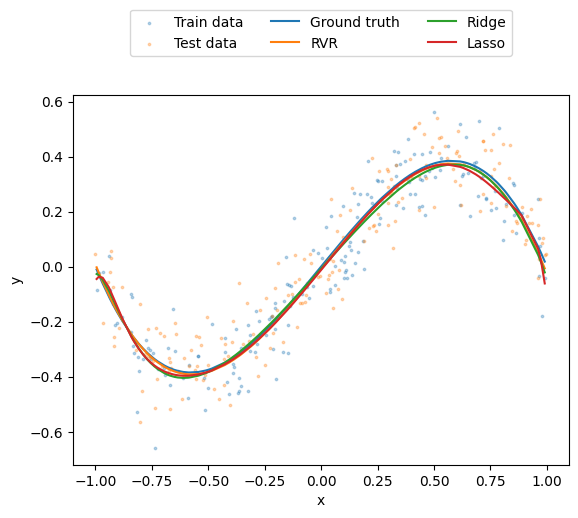

In [26]:
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
ax.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
ax.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
ax.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром, обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

In [27]:
# Data generation
def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 200
n_test = 1000
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n_test, beta_true)

# RBF-transform
X_train = rbf_kernel(points_train[:, None], points_train[:, None])
X_test = rbf_kernel(points_test[:, None], points_train[:, None])

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n_test, 1)), X_test))

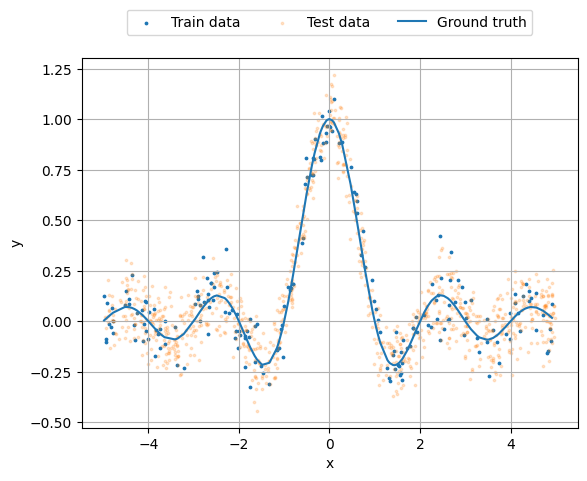

In [28]:
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=1)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.2)
ax.plot(points_train, np.sinc(points_train), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
ax.grid()
plt.show()

In [29]:
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [30]:
lasso = LassoCV(cv=10, alphas=10.**np.linspace(-5, 1, 20),
                fit_intercept=False, max_iter=100000, tol=1e-2, n_jobs=10).fit(X_train, t_train)
w_lasso = lasso.coef_

In [31]:
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

Relevance Vector Regression
Objects remaining: 8 / 200
Train error: 0.007990587212897308
Test error:  0.05408788325800666
--------------------------------------------------
Lasso Regression
Objects remaining: 63 / 200
Train error: 0.009447935993241242
Test error:  0.057053745050616646
--------------------------------------------------
Support Vector Regression
Objects remaining: 59 / 200
Train error: 0.008025457213352068
Test error:  0.05380997349742385


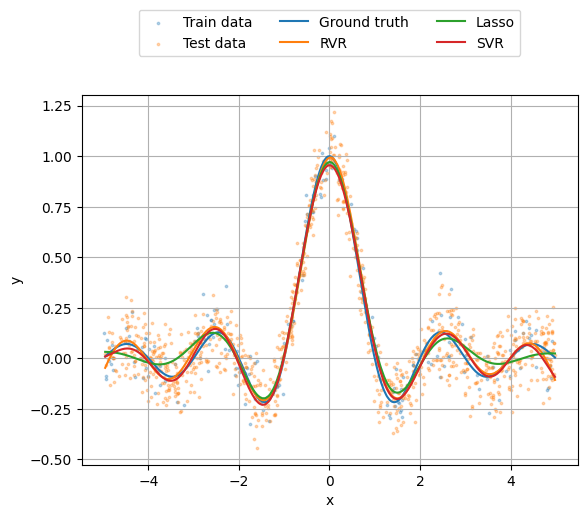

In [32]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')
ax.plot(points_test, X_test.dot(w_lasso), label='Lasso')
ax.plot(points_test, svr.predict(points_test.reshape(-1, 1)), label='SVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
ax.grid()
plt.show()

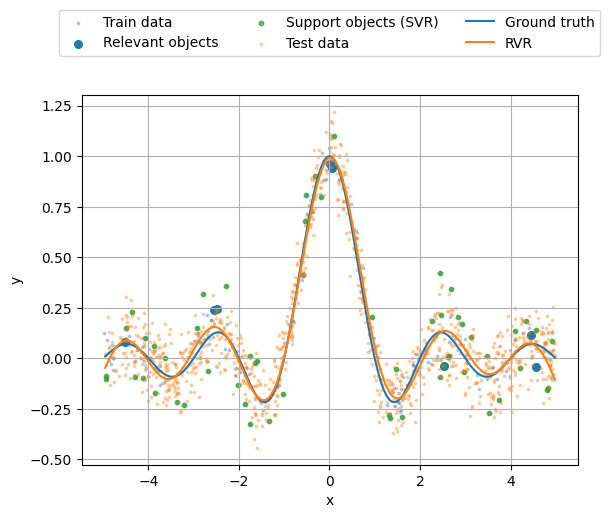

In [33]:
relevant = alpha_rvr[1:] < 1e8
support_svr = svr.support_[svr.support_ != 0]
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
ax.scatter(points_train[support_svr], t_train[support_svr], c='tab:green', s=10, alpha=0.7, label='Support objects (SVR)')
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
ax.grid()
plt.show()